#### Model with the unsampled dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split
from typing import Dict, List, Tuple, Optional
import math
from imblearn.under_sampling import RandomUnderSampler


%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
df = pd.read_csv('day_approach_maskedID_timeseries.csv')

In [3]:
df.head(5)

,nr. sessions,total km,km Z3-4,km Z5-T1-T2,km sprinting,strength training,hours alternative,perceived exertion,perceived trainingSuccess,perceived recovery,...,km Z5-T1-T2.6,km sprinting.6,strength training.6,hours alternative.6,perceived exertion.6,perceived trainingSuccess.6,perceived recovery.6,Athlete ID,injury,Date
0,1.0,5.8,0.0,0.6,1.2,0.0,0.00,0.11,0.00,0.18,...,0.0,0.0,0.0,1.0,0.10,0.00,0.15,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,...,0.5,1.2,0.0,0.0,0.10,0.00,0.17,0,0,1
2,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,...,0.0,0.0,0.0,0.0,-0.01,-0.01,-0.01,0,0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,...,0.0,0.0,1.0,0.0,0.10,0.00,0.17,0,0,3
4,1.0,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,...,0.0,0.0,0.0,0.0,0.11,0.00,0.17,0,0,4


In [4]:
print(df.shape)

(42766, 73)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   nr. sessions                 42766 non-null  float64
 1   total km                     42766 non-null  float64
 2   km Z3-4                      42766 non-null  float64
 3   km Z5-T1-T2                  42766 non-null  float64
 4   km sprinting                 42766 non-null  float64
 5   strength training            42766 non-null  float64
 6   hours alternative            42766 non-null  float64
 7   perceived exertion           42766 non-null  float64
 8   perceived trainingSuccess    42766 non-null  float64
 9   perceived recovery           42766 non-null  float64
 10  nr. sessions.1               42766 non-null  float64
 11  total km.1                   42766 non-null  float64
 12  km Z3-4.1                    42766 non-null  float64
 13  km Z5-T1-T2.1   

In [6]:
df.isnull().sum()

nr. sessions                   0
total km                       0
km Z3-4                        0
km Z5-T1-T2                    0
km sprinting                   0
                              ..
perceived trainingSuccess.6    0
perceived recovery.6           0
Athlete ID                     0
injury                         0
Date                           0
Length: 73, dtype: int64

In [7]:
df.drop(['Date', 'Athlete ID'], axis = 1, inplace = True)

In [8]:
df.columns

Index(['nr. sessions', 'total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting',
       'strength training', 'hours alternative', 'perceived exertion',
       'perceived trainingSuccess', 'perceived recovery', 'nr. sessions.1',
       'total km.1', 'km Z3-4.1', 'km Z5-T1-T2.1', 'km sprinting.1',
       'strength training.1', 'hours alternative.1', 'perceived exertion.1',
       'perceived trainingSuccess.1', 'perceived recovery.1', 'nr. sessions.2',
       'total km.2', 'km Z3-4.2', 'km Z5-T1-T2.2', 'km sprinting.2',
       'strength training.2', 'hours alternative.2', 'perceived exertion.2',
       'perceived trainingSuccess.2', 'perceived recovery.2', 'nr. sessions.3',
       'total km.3', 'km Z3-4.3', 'km Z5-T1-T2.3', 'km sprinting.3',
       'strength training.3', 'hours alternative.3', 'perceived exertion.3',
       'perceived trainingSuccess.3', 'perceived recovery.3', 'nr. sessions.4',
       'total km.4', 'km Z3-4.4', 'km Z5-T1-T2.4', 'km sprinting.4',
       'strength training.4',

In [9]:
df['nr. sessions'] = df['nr. sessions'].astype(int)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 71 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   nr. sessions                 42766 non-null  int32  
 1   total km                     42766 non-null  float64
 2   km Z3-4                      42766 non-null  float64
 3   km Z5-T1-T2                  42766 non-null  float64
 4   km sprinting                 42766 non-null  float64
 5   strength training            42766 non-null  float64
 6   hours alternative            42766 non-null  float64
 7   perceived exertion           42766 non-null  float64
 8   perceived trainingSuccess    42766 non-null  float64
 9   perceived recovery           42766 non-null  float64
 10  nr. sessions.1               42766 non-null  float64
 11  total km.1                   42766 non-null  float64
 12  km Z3-4.1                    42766 non-null  float64
 13  km Z5-T1-T2.1   

In [11]:
print(df['injury'].nunique())
print(df.injury.value_counts())

2
0    42183
1      583
Name: injury, dtype: int64


In [12]:
x= ['nr. sessions', 'total km', 'km Z3-4', 'km Z5-T1-T2', 'km sprinting',
       'strength training', 'hours alternative', 'perceived exertion',
       'perceived trainingSuccess', 'perceived recovery', 'nr. sessions.1',
       'total km.1', 'km Z3-4.1', 'km Z5-T1-T2.1', 'km sprinting.1',
       'strength training.1', 'hours alternative.1', 'perceived exertion.1',
       'perceived trainingSuccess.1', 'perceived recovery.1', 'nr. sessions.2',
       'total km.2', 'km Z3-4.2', 'km Z5-T1-T2.2', 'km sprinting.2',
       'strength training.2', 'hours alternative.2', 'perceived exertion.2',
       'perceived trainingSuccess.2', 'perceived recovery.2', 'nr. sessions.3',
       'total km.3', 'km Z3-4.3', 'km Z5-T1-T2.3', 'km sprinting.3',
       'strength training.3', 'hours alternative.3', 'perceived exertion.3',
       'perceived trainingSuccess.3', 'perceived recovery.3', 'nr. sessions.4',
       'total km.4', 'km Z3-4.4', 'km Z5-T1-T2.4', 'km sprinting.4',
       'strength training.4', 'hours alternative.4', 'perceived exertion.4',
       'perceived trainingSuccess.4', 'perceived recovery.4', 'nr. sessions.5',
       'total km.5', 'km Z3-4.5', 'km Z5-T1-T2.5', 'km sprinting.5',
       'strength training.5', 'hours alternative.5', 'perceived exertion.5',
       'perceived trainingSuccess.5', 'perceived recovery.5', 'nr. sessions.6',
       'total km.6', 'km Z3-4.6', 'km Z5-T1-T2.6', 'km sprinting.6',
       'strength training.6', 'hours alternative.6', 'perceived exertion.6',
       'perceived trainingSuccess.6', 'perceived recovery.6']
y= 'injury'

In [13]:
#splitting the dataet into training, validation and test set
test_size = 0.1
val_size = 0.2

df_train, df_test = train_test_split( df,test_size=test_size, random_state=0,stratify=df['injury'])

df_train, df_val = train_test_split(df_train,test_size=val_size,random_state=0,stratify=df_train['injury'])

print('train shape: ', df_train.shape)
print('validation shape: ', df_val.shape)
print('test shape: ', df_test.shape)


train shape:  (30791, 71)
validation shape:  (7698, 71)
test shape:  (4277, 71)


In [14]:
df_train.injury.value_counts()

0    30371
1      420
Name: injury, dtype: int64

In [15]:
x_train = df_train.drop(columns = ['injury'], errors='ignore')
y_train = df_train['injury']

In [16]:
# using RandomUnderSampling only on the training data to handle this.

undersample = RandomUnderSampler(sampling_strategy='majority')
x_train_balanced, y_train_balanced = undersample.fit_sample(x_train, y_train)
#value count our y_train_balanced to cross check the effect of smote on the dataset
y_train_balanced.value_counts()

0    420
1    420
Name: injury, dtype: int64

In [17]:
#Standard scaler for the training set
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_train_df = scaler.fit_transform(x_train_balanced)
normalized_train_df = pd.DataFrame(normalized_train_df, columns = x_train_balanced.columns)


#adding the y_train_balanced column back
normalized_train_df['injury'] = y_train_balanced

In [18]:
# training the model
model_xgb = XGBClassifier( max_depth = 6, learning_rate = 0.01, importance_type = 'total_gain', eval_metric = 'auc' , verbosity=1)

# fitting the model
model_xgb.fit(normalized_train_df[x].values, normalized_train_df[y].values)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type='total_gain', interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [19]:
def compute_binary_score(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    round_digits: int=3) -> float:
    """Computing various evaluation metrics for the classification.Including auc, precision, recall, f1, log loss, brier score. 
    The threshold for precision and recall numbers are based on the one that gives the best f1 score.
    Parameters:
    y_true : 1d ndarray(Binary true targets).
    y_prob : 1d ndarray (Raw probability/score of the positive class).
    round_digits : int, default 4 (Round the evaluation metric).
    """
    auc = round(metrics.roc_auc_score(y_true, y_prob), round_digits)
    log_loss = round(metrics.log_loss(y_true, y_prob), round_digits)
    brier_score = round(metrics.brier_score_loss(y_true, y_prob), round_digits)

    precision, recall, threshold = metrics.precision_recall_curve(y_true, y_prob)
    f1 = 2 * (precision * recall) / (precision + recall)

    mask = ~np.isnan(f1)
    f1 = f1[mask]
    precision = precision[mask]
    recall = recall[mask]

    best_index = np.argmax(f1)
    precision = round(precision[best_index], round_digits)
    recall = round(recall[best_index], round_digits)
    f1 = round(f1[best_index], round_digits)
    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'log_loss': log_loss,
        'brier': brier_score
    }

In [20]:
# evaluating the metrics for training and validation set
estimators = {'xgb': model_xgb}
df_groups = {'train':normalized_train_df,'val': df_val}

estimator_metrics = []
for name, estimator in estimators.items():
    for df_name, df_group in df_groups.items():
        y_prob = estimator.predict_proba(df_group[x].values)[:, 1]
        # computing different binary classification metrics
        metric_dict = compute_binary_score(df_group[y], y_prob)
        metric_dict['name'] = name + '_' + df_name
        estimator_metrics.append(metric_dict)

df_metrics = pd.DataFrame(estimator_metrics)
df_metrics


C:\Users\USER\AppData\Local\Temp\ipykernel_16032\3247087562.py:17: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * (precision * recall) / (precision + recall)


,auc,precision,recall,f1,log_loss,brier,name
0,0.958,0.944,0.879,0.910,0.504,0.159,xgb_train
1,0.609,0.040,0.143,0.062,0.669,0.238,xgb_val


In [21]:
# extracting the validation and test true label and predicted probability,
# Working with binary classification in this use case, we can extract the predicted probability for the positive class
y_val = df_val[y].values
xgb_pred_val = model_xgb.predict_proba(df_val[x].values)[:, 1]

y_test = df_test[y].values
xgb_pred_test = model_xgb.predict_proba(df_test[x].values)[:, 1]

In [22]:
 #calibrating the xgboost model it with the given X_val data
calib_model = CalibratedClassifierCV(model_xgb, cv="prefit")
calib_model.fit(df_val[x].values, y_val)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    callbacks=None,
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=False,
                                                    eval_metric='auc', gamma=0,
                                                    gpu_id=-1,
                                                    grow_policy='depthwise',
                                                    importance_type='total_gain',
                                                    interaction_constraints='',
                                     

In [23]:
# Bin y_true and y_prob by distribution of the data.
def create_binned_data(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    n_bins: int) -> Tuple[List[np.ndarray], List[np.ndarray]]:
 
    #binned_y_true/binned_y_prob : 1d ndarray(Each element in the list stores the data for that bin).
    sorted_indices = np.argsort(y_prob)
    sorted_y_true = y_true[sorted_indices]
    sorted_y_prob = y_prob[sorted_indices]
    binned_y_true = np.array_split(sorted_y_true, n_bins)
    binned_y_prob = np.array_split(sorted_y_prob, n_bins)
    return binned_y_true, binned_y_prob#

# getting the boundaries of each bin
def get_bin_boundaries(binned_y_prob: List[np.ndarray]) -> np.ndarray:

# bins : 1d ndarray(Boundaries for each bin).
    bins = []
    for i in range(len(binned_y_prob) - 1):
        last_prob = binned_y_prob[i][-1]
        next_first_prob = binned_y_prob[i + 1][0]
        bins.append((last_prob + next_first_prob) / 2.0)

    bins.append(1.0)
    return np.array(bins)

In [24]:
#Computing the calibration error for the classification via binningdata points into specified number of bins. 
#Samples with similar`y_prob` will be grouped into the same bin. The bin boundary is determined by having similar number of samples within each bin.
def compute_calibration_error(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    n_bins: int=16,
    round_digits: int=3):
    """

    calibration_error : float
        RMSE between the average positive label and predicted probability
        within each bin.
    """
    #y_true = column_or_1d(y_true)
    #y_prob = column_or_1d(y_prob)
    #check_consistent_length(y_true, y_prob)

    binned_y_true, binned_y_prob = create_binned_data(y_true, y_prob, n_bins)

    # looping since n_bins should be a small number.
    bin_errors = 0.0
    for bin_y_true, bin_y_prob in zip(binned_y_true, binned_y_prob):
        avg_y_true = np.mean(bin_y_true)
        avg_y_score = np.mean(bin_y_prob)
        bin_error = (avg_y_score - avg_y_true) ** 2
        bin_errors += bin_error * len(bin_y_true)

    calibration_error = math.sqrt(bin_errors / len(y_true))
    return round(calibration_error, round_digits)

In [25]:
# Plots for the calibration curve and computing the summary statistics for the model 
def compute_calibration_summary(
    eval_dict: Dict[str, pd.DataFrame],
    y: str='label',
    score_col: str='score',
    n_bins: int=16,
    strategy: str='quantile',
    round_digits: int=3,
    show: bool=True,
    save_plot_path: Optional[str]=None) -> pd.DataFrame:

    fig, (ax1, ax2) = plt.subplots(2)

    # estimator_metrics 
    estimator_metrics = []
    for name, df_eval in eval_dict.items():
        prob_true, prob_pred = calibration_curve(df_eval[y],df_eval[score_col],n_bins=n_bins,strategy=strategy)

        calibration_error = compute_calibration_error(df_eval[y], df_eval[score_col], n_bins, round_digits)
        metrics_dict = compute_binary_score(df_eval[y], df_eval[score_col], round_digits)
        metrics_dict['calibration_error'] = calibration_error
        metrics_dict['name'] = name
        estimator_metrics.append(metrics_dict)

        ax1.plot(prob_pred, prob_true, 's-', label=name)
        ax2.hist(df_eval[score_col], range=(0, 1), bins=n_bins, label=name, histtype='step', lw=2)

    ax1.plot([0, 1], [0, 1], 'k:', label='perfect')

    ax1.set_xlabel('Predicted Fraction of positives')
    ax1.set_ylabel('Actual Fraction of positives ')
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc='upper left', ncol=2)
    ax1.set_title('Calibration Plots (Reliability Curve)')

    ax2.set_xlabel('Predicted scores')
    ax2.set_ylabel('Count')
    ax2.set_title('Histogram of Predicted Scores')
    ax2.legend(loc='upper right', ncol=2)

    plt.tight_layout()
    if show:
        plt.show()

    if save_plot_path is not None:
        save_dir = os.path.dirname(save_plot_path)
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        fig.savefig(save_plot_path, dpi=300, bbox_inches='tight')

    plt.close(fig)

    df_metrics = pd.DataFrame(estimator_metrics)
    return df_metrics

C:\Users\USER\AppData\Local\Temp\ipykernel_16032\3247087562.py:17: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * (precision * recall) / (precision + recall)
C:\Users\USER\AppData\Local\Temp\ipykernel_16032\3247087562.py:17: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2 * (precision * recall) / (precision + recall)


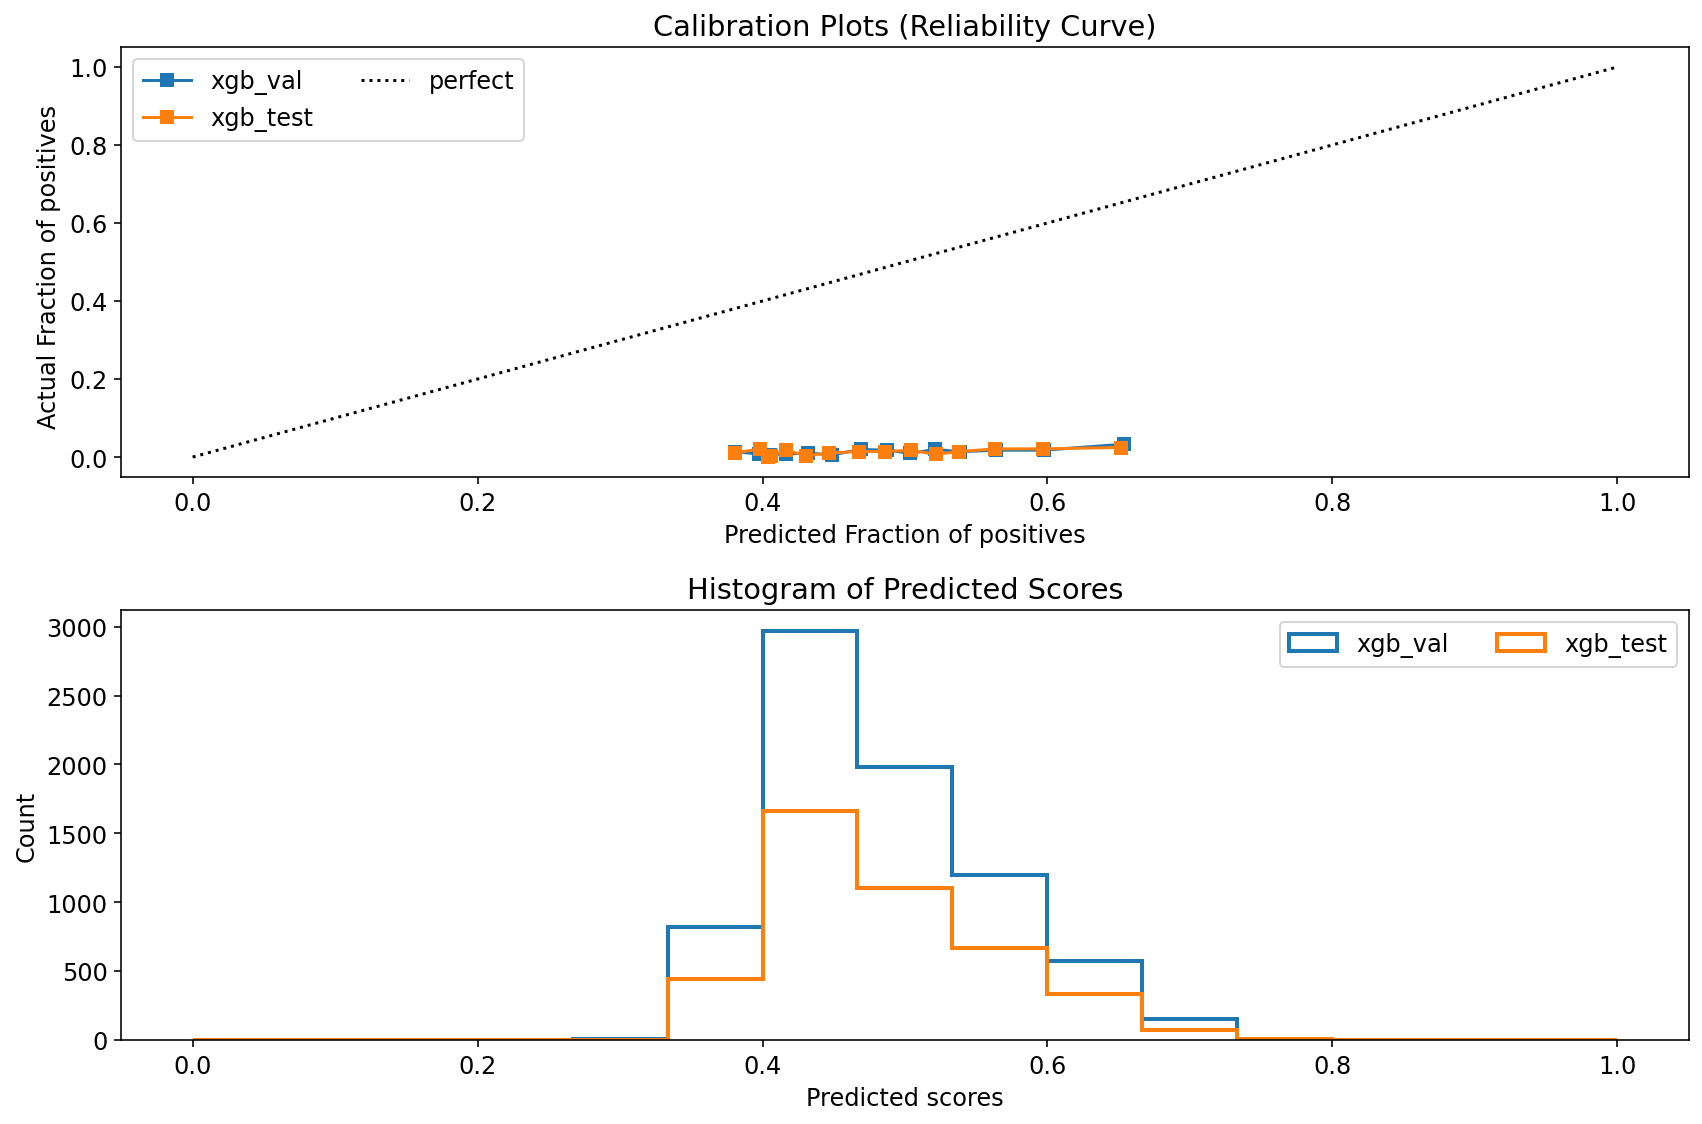

,auc,precision,recall,f1,log_loss,brier,calibration_error,name
0,0.609,0.040,0.143,0.062,0.669,0.238,0.473,xgb_val
1,0.577,0.027,0.172,0.047,0.668,0.237,0.473,xgb_test


In [26]:
# linking the label and probability into a dataframe
score_col = 'score'
df_xgb_eval_val = pd.DataFrame({y: y_val,score_col: xgb_pred_val})

df_xgb_eval_test = pd.DataFrame({y: y_test,score_col: xgb_pred_test})

eval_dict = {
    'xgb_val': df_xgb_eval_val,
    'xgb_test': df_xgb_eval_test
}

# changing default style figure and font size
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 12

n_bins = 15
df_result = compute_calibration_summary(eval_dict, y, score_col, n_bins=n_bins)
df_result


Text(0.5, 1.0, 'Calibration plots  (reliability curve)')

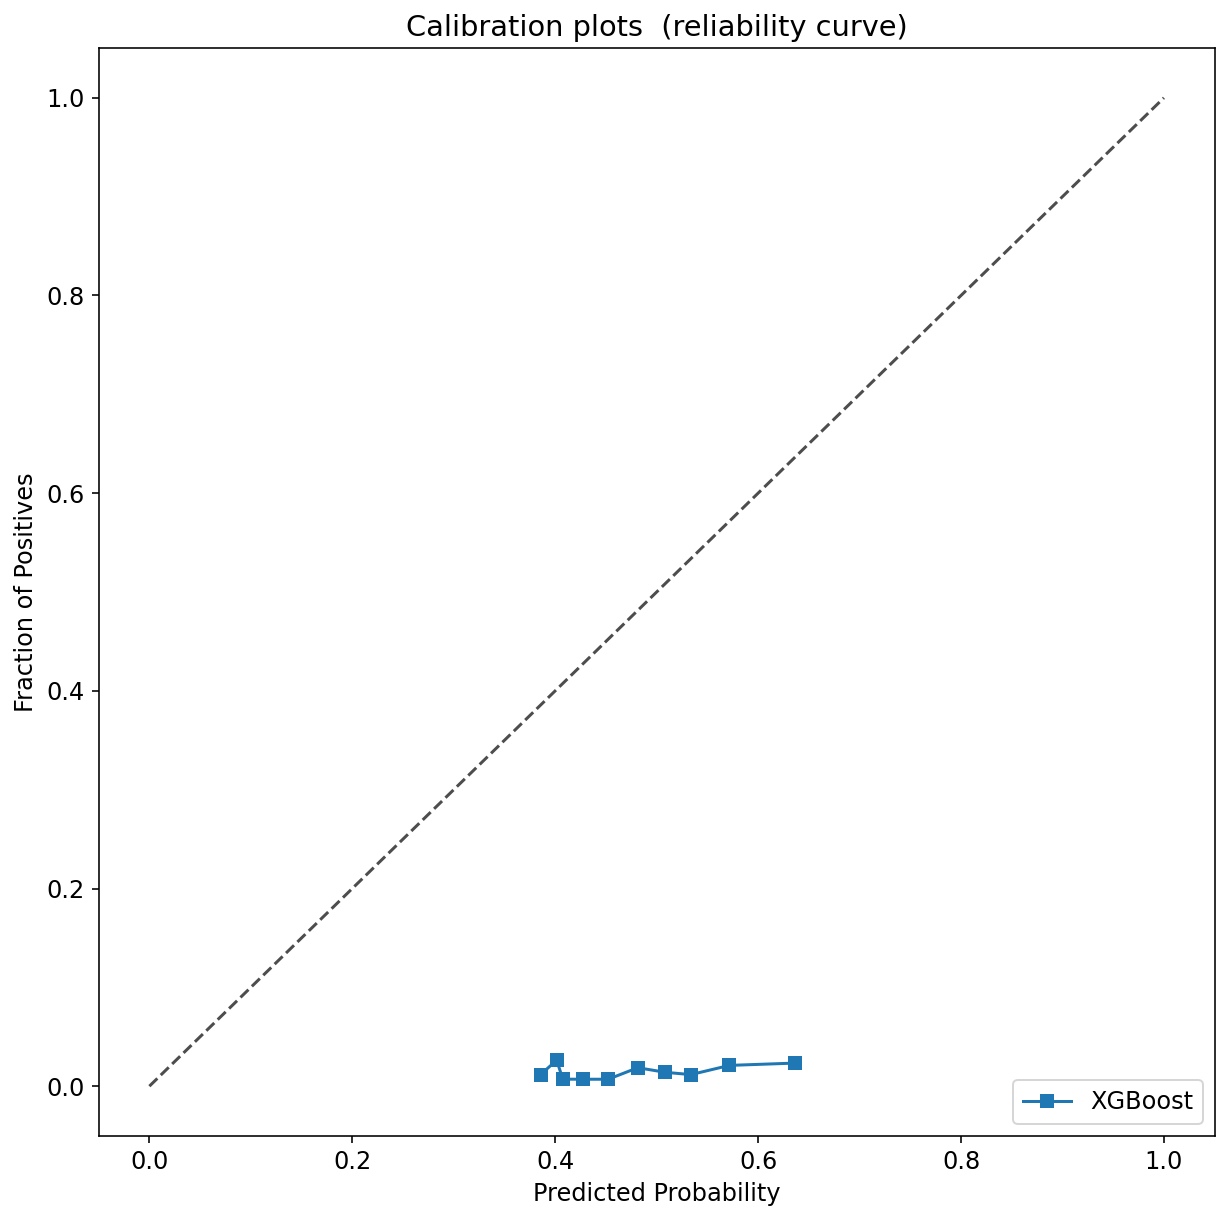

In [27]:
# plottinga calibration with the given y_test and y_pred values
fig = plt.figure(1, figsize=(10, 10))
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, xgb_pred_test, n_bins=10, strategy='quantile')

plt.plot(mean_predicted_value, fraction_of_positives, "s-",label="XGBoost")
plt.plot([0, 1],[0, 1], ls="--", c="0.3")
plt.ylabel("Fraction of Positives")
plt.xlabel("Predicted Probability")
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
plt.legend(loc = "lower right")
plt.title('Calibration plots  (reliability curve)')

The model is also performing poorly with the dataset, even after resampling. The scores are really poor, but better than the imbalanced dataset model


`Please if there is any form of correction, you can drawn my attention to it. I will glad to recieve contributions and correction. For any form of clarification, you can also ask.`